# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
import imageio as imgio
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale, resize

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

(360, 360)

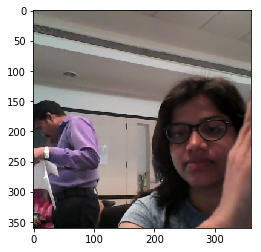

In [5]:
#displaying sample image
image = imgio.imread('Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
plt.imshow(image)
image.shape[:2]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


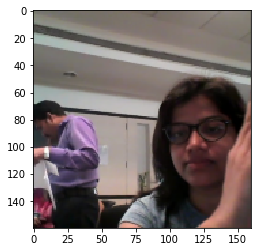

In [6]:
#resizing image to 160x160
plt.imshow(resize(image,(160,160),anti_aliasing=True))

(120, 160)

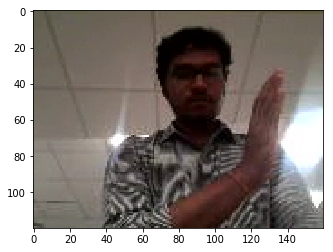

In [7]:
#displaying sample image
image = imgio.imread('Project_data/train/WIN_20180926_18_09_50_Pro_Right_Swipe_new/WIN_20180926_18_09_50_Pro_00013.png')
plt.imshow(image)
image.shape[:2]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


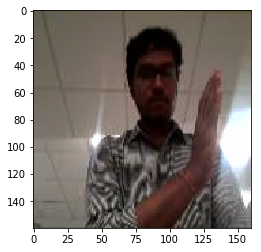

In [8]:
#resizing image to 160x160
plt.imshow(resize(image,(160,160),anti_aliasing=True))

In [9]:
batch_size = 16

In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,3,6,9,12,15,18,21,24,27] #create a list of image numbers you want to use for a particular video
    while True:
        x = len(img_idx)
        y = 160
        z = 160
        t = np.random.permutation(folder_list)
        t_length = len(t)
        num_batches = t_length//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imgio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    reshaped_image = (resize(image,(160,160),anti_aliasing=True))
                        #resize image
                    batch_data[folder,idx,:,:,0] = reshaped_image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] =  reshaped_image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] =  reshaped_image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        difference = t_length - num_batches*batch_size
        
        if difference > 0 :
            max_batch_size = num_batches
            batch_data = np.zeros((difference,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((difference,5)) # batch_labels is the one hot representation of the output
            for folder in range(difference): # iterate over the difference
                imgs = os.listdir(source_path+'/'+ t[folder + (batch_size*max_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imgio.imread(source_path+'/'+ t[folder + (batch_size*max_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    reshaped_image = (resize(image,(160,160),anti_aliasing=True))
                        #resize image
                    batch_data[folder,idx,:,:,0] = reshaped_image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] =  reshaped_image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] =  reshaped_image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch_size*max_batch_size)].strip().split(';')[2])] = 1
            
    print( 'batch_labels = ', batch_labels, '; batch_data =', batch_data)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
#num_train_sequences = 40
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
#num_val_sequences = 20
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here


### Experiment 1:  Convolution 2D + RNN
#### Using base model + conv2d layer+ flattening + gru+ dense


In [15]:
#Model 2D conv + RNN

def get_model_conv2d_rnn():
    
    features = 64
    time_steps = 10
    n_classes = 5
    activation='softmax'
    n_cells = 64

    #using sequential model provided by Keras
    model = Sequential()
    #adding time distributed functionality to first layer with 2D conv
    model.add(TimeDistributed(Conv2D(features, (5,5), padding='same', strides=(2,2) , activation='relu'), input_shape=(time_steps, 160, 160, 3)))
    #feed one dimesion to the LSTM layer by flattening or pooling
    model.add(TimeDistributed(Flatten()))
    
    # add GRU layer
    model.add(GRU(n_cells, input_shape=(time_steps, features)))
    # output layer
    model.add(Dense(n_classes, activation=activation))

    return model


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [16]:
model = get_model_conv2d_rnn()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 80, 80, 64)    4864      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 409600)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                78655680  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 78,660,869
Trainable params: 78,660,869
Non-trainable params: 0
_________________________________________________________________
None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'Model/model_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 16
Source path =  Project_data/trainEpoch 1/5
 ; batch size = 16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 75s 2s/step - loss: 1.7121 - categorical_accuracy: 0.2307 - val_loss: 1.5590 - val_categorical_accuracy: 0.3571

Epoch 00001: saving model to Model/model_1_2020-05-0310_57_24.132051/model-00001-1.71214-0.23065-1.55896-0.35714.h5
Epoch 2/5
42/42 [==============================] - 67s 2s/step - loss: 1.5420 - categorical_accuracy: 0.3378 - val_loss: 1.4168 - val_categorical_accuracy: 0.4375

Epoch 00002: saving model to Model/model_1_2020-05-0310_57_24.132051/model-00002-1.54201-0.33780-1.41681-0.43750.h5
Epoch 3/5
42/42 [==============================] - 66s 2s/step - loss: 1.3656 - categorical_accuracy: 0.4226 - val_loss: 1.3160 - val_categorical_accuracy: 0.4464

Epoch 00003: saving model to Model/model_1_2020-05-0310_57_24.132051/model-00003-1.36564-0.42262-1.31603-0.44643.h5
Epoch 4/5
42/42 [==============================] - 72s 2s/step - loss: 1.1613 - categorical_accuracy: 0.5223 - val_loss: 1.1756 - val_categorical_accuracy: 0.4821

Epoch 

### Experiment 2:  Multiple Dense + GRU

#### Using base model + (2 or 3) conv2d layer+ flattening + gru+ dense

In [66]:
def get_model_conv2d_rnn_dense():
    
    features = 32
    time_steps = 10
    n_classes = 5
    activation='softmax'
    n_cells = 32

    #using sequential model provided by Keras
    model = Sequential()
    #adding time distributed functionality to first layer with 2D conv
    model.add(TimeDistributed(Conv2D(features, (3,3), padding='same', strides=(2,2) , activation='relu'), input_shape=(time_steps, 160, 160, 3)))
    model.add(TimeDistributed(Conv2D(features, (3,3), padding='same', strides=(2,2) , activation='relu')))

    #feed one dimesion to the LSTM layer by flattening or pooling
    model.add(TimeDistributed(Flatten()))
    
    # add GRU layer
    model.add(GRU(features, activation='relu', return_sequences=False))
  #  model.add(GRU(16, input_shape=(time_steps, 51200)))
    # output layer
    model.add(Dense(n_classes, activation=activation))

    return model


In [67]:
model2 = get_model_conv2d_rnn_dense()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_55 (TimeDis (None, 10, 80, 80, 32)    896       
_________________________________________________________________
time_distributed_56 (TimeDis (None, 10, 40, 40, 32)    9248      
_________________________________________________________________
time_distributed_57 (TimeDis (None, 10, 51200)         0         
_________________________________________________________________
gru_16 (GRU)                 (None, 32)                4918368   
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 165       
Total params: 4,928,677
Trainable params: 4,928,677
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [75]:
model_name = 'Model/model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [76]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [77]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 16
Source path =  Project_data/train ; batch size = 16
Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 144s 3s/step - loss: 1.5947 - categorical_accuracy: 0.2292 - val_loss: 1.5784 - val_categorical_accuracy: 0.2679

Epoch 00001: saving model to Model/model_2_2020-05-0218_09_33.633200/model-00001-1.59474-0.22917-1.57836-0.26786.h5
Epoch 2/5
42/42 [==============================] - 121s 3s/step - loss: 1.4884 - categorical_accuracy: 0.3690 - val_loss: 1.4872 - val_categorical_accuracy: 0.4018

Epoch 00002: saving model to Model/model_2_2020-05-0218_09_33.633200/model-00002-1.48843-0.36905-1.48721-0.40179.h5
Epoch 3/5
42/42 [==============================] - 120s 3s/step - loss: 1.2826 - categorical_accuracy: 0.4896 - val_loss: 1.4970 - val_categorical_accuracy: 0.3214

Epoch 00003: saving model to Model/model_2_2020-05-0218_09_33.633200/model-00003-1.28264-0.48958-1.49700-0.32143.h5
Epoch 4/5
42/42 [==============================] - 121s 3s/step - loss: 1.0477 - categorical_accuracy: 0.5982 - val_loss: 1.5424 - val_categorical_accuracy: 0.4107

Ep

### Experiment 3:  Transfer Learning + RNN - experiment 3

#### Using transfer learning vgg model + conv2d layer+ flattening + gru+ dense

In [20]:
#Model vgg + RNN
# number of classes 
num_classes = 5

from keras.applications.vgg16 import VGG16

def get_model_with_transfer_learning():
    
    features = 64
    time_steps = 10
    n_classes = 5
    activation='softmax'
    n_cells = 64

    # create a VGG16 "model", we will use
    vgg = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(160, 160, 3)
    )
    
    # the 4 last layers 
    for layer in vgg.layers[:-4]:
        layer.trainable = False

    #using sequential model provided by Keras
    model = Sequential()

    #adding time distributed to vgg model
    model.add(TimeDistributed(vgg , input_shape=(time_steps, 160, 160, 3)))
 
    #feed one dimesion to the LSTM layer by flattening or pooling
    model.add(TimeDistributed(Flatten()))
    
    # add GRU layer
    model.add(GRU(features, input_shape=(time_steps, features)))
    # output layer
    model.add(Dense(n_classes, activation=activation))
    
    return model

In [21]:
model3 = get_model_with_transfer_learning()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 10, 5, 5, 512)     14714688  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 12800)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                2470080   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 17,185,093
Trainable params: 9,549,829
Non-trainable params: 7,635,264
_________________________________________________________________
None


In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'Model/model_vgg' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val Source path =  Project_data/train ; batch size = 16
Epoch 1/5
; batch size = 16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 79s 2s/step - loss: 1.8030 - categorical_accuracy: 0.2039 - val_loss: 1.6231 - val_categorical_accuracy: 0.2143

Epoch 00001: saving model to Model/model_vgg_2020-05-0221_55_32.443624/model-00001-1.80304-0.20387-1.62308-0.21429.h5
Epoch 2/5
42/42 [==============================] - 71s 2s/step - loss: 1.6523 - categorical_accuracy: 0.1920 - val_loss: 1.6467 - val_categorical_accuracy: 0.1696

Epoch 00002: saving model to Model/model_vgg_2020-05-0221_55_32.443624/model-00002-1.65231-0.19196-1.64670-0.16964.h5
Epoch 3/5
42/42 [==============================] - 78s 2s/step - loss: 1.6594 - categorical_accuracy: 0.1607 - val_loss: 1.6016 - val_categorical_accuracy: 0.2143

Epoch 00003: saving model to Model/model_vgg_2020-05-0221_55_32.443624/model-00003-1.65938-0.16071-1.60159-0.21429.h5
Epoch 4/5
42/42 [==============================] - 76s 2s/step - loss: 1.6550 - categorical_accuracy: 0.2054 - val_loss: 1.6069 - val_categorical_accuracy: 0.2500



### Experiment 4:  Transfer Learning + RNN - experiment 3

#### Using transfer learning resnet model + conv2d layer+ flattening + gru+ dense

In [14]:
#Model resnet + RNN
# number of classes 
num_classes = 5

from keras.applications.resnet50 import ResNet50

def get_model_with_transfer_learning_resnet():
    
    features = 1024
    time_steps = 10
    n_classes = 5
    activation='softmax'
    n_cells = 64

    # create a VGG16 "model", we will use
    resnet = ResNet50(
        include_top=False,
        weights='imagenet',
    )
    
    # the 4 last layers 
    for layer in resnet.layers[:-10]:
        layer.trainable = False

    #using sequential model provided by Keras
    model = Sequential()

    #adding time distributed to vgg model
    model.add(TimeDistributed(resnet , input_shape=(time_steps, 160, 160, 3)))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(Conv2D(features, (3,3), padding='same', strides=(2,2) , activation='relu')))

    #feed one dimesion to the LSTM layer by flattening or pooling
    model.add(TimeDistributed(Flatten()))

    # add GRU layer
    model.add(GRU(features, input_shape=(time_steps, features)))
    # output layer
    model.add(Dense(n_classes, activation=activation))
    
    return model

In [15]:
model4 = get_model_with_transfer_learning_resnet()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 5, 5, 2048)    23587712  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 5, 5, 2048)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 3, 3, 1024)    18875392  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 9216)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1024)              31460352  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 73,928,581
Trainable params: 54,806,533
Non-trainable params: 1

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Model/model_resnet' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 16
Source path =  Project_data/train ; batch size = Epoch 1/5
16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 188s 4s/step - loss: 9.8374 - categorical_accuracy: 0.2054 - val_loss: 10.1711 - val_categorical_accuracy: 0.2232

Epoch 00001: saving model to Model/model_resnet_2020-05-0310_27_01.833914/model-00001-9.83738-0.20536-10.17107-0.22321.h5
Epoch 2/5
42/42 [==============================] - 72s 2s/step - loss: 10.4199 - categorical_accuracy: 0.2098 - val_loss: 9.2359 - val_categorical_accuracy: 0.2321

Epoch 00002: saving model to Model/model_resnet_2020-05-0310_27_01.833914/model-00002-10.41995-0.20982-9.23592-0.23214.h5
Epoch 3/5
42/42 [==============================] - 76s 2s/step - loss: 10.0753 - categorical_accuracy: 0.2128 - val_loss: 8.8264 - val_categorical_accuracy: 0.2143

Epoch 00003: saving model to Model/model_resnet_2020-05-0310_27_01.833914/model-00003-10.07532-0.21280-8.82636-0.21429.h5
Epoch 4/5
42/42 [==============================] - 75s 2s/step - loss: 10.1909 - categorical_accuracy: 0.2098 - val_loss: 10.0668 - val_categorical_

### Experiment 5:  CONV3D

#### Using transfer learning model + conv3d layer+ flattening 

In [61]:
#Model 2D conv + RNN

def get_model_conv3d_exp1():
    
    time_steps = 10
    n_classes = 5
    activation='softmax'

    #using sequential model provided by Keras
    model = Sequential()
    #adding time distributed functionality to first layer with 3D conv
    model.add(TimeDistributed(Conv3D(64, (5,5,5), strides=(2,2,1) , activation='relu', input_shape=(time_steps, 160, 160, 3))))
    model.add(TimeDistributed(Conv3D(64, (5,5,5), strides=(2,2,1) , activation='relu')))
    model.add(TimeDistributed(MaxPooling3D((2,2,2))))

    model.add(TimeDistributed(Conv3D(32, (3,3,3), strides=(2,2,1) , activation='relu')))
    model.add(TimeDistributed(MaxPooling3D((2,2,2))))
   
    # output layer
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_classes, activation=activation))

    return model

In [63]:
def get_model_conv3d_exp1():
    time_steps = 10
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(time_steps, 160, 160, 3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [64]:
model5 = get_model_conv3d_exp1()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 8, 158, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 4, 79, 79, 32)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 79, 79, 32)     128       
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 2, 77, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 1, 38, 38, 64)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 38, 38, 64)     256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 92416)             0         
__________

In [65]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Model/model_conv3D_exp1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 16
Source path =  Project_data/train ; batch size = 16
Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 69s 2s/step - loss: 11.0513 - categorical_accuracy: 0.2827 - val_loss: 13.0147 - val_categorical_accuracy: 0.1875

Epoch 00001: saving model to Model/model_conv3D_exp1_2020-05-0311_32_58.204165/model-00001-11.05130-0.28274-13.01466-0.18750.h5
Epoch 2/5
42/42 [==============================] - 67s 2s/step - loss: 11.9694 - categorical_accuracy: 0.2545 - val_loss: 13.6716 - val_categorical_accuracy: 0.1518

Epoch 00002: saving model to Model/model_conv3D_exp1_2020-05-0311_32_58.204165/model-00002-11.96941-0.25446-13.67160-0.15179.h5
Epoch 3/5
42/42 [==============================] - 62s 1s/step - loss: 12.7122 - categorical_accuracy: 0.2113 - val_loss: 12.9520 - val_categorical_accuracy: 0.1964

Epoch 00003: saving model to Model/model_conv3D_exp1_2020-05-0311_32_58.204165/model-00003-12.71219-0.21131-12.95204-0.19643.h5
Epoch 4/5
42/42 [==============================] - 63s 2s/step - loss: 11.6874 - categorical_accuracy: 0.2738 - val_loss: 12.520

### Experiment 6: CONV3D varying batch size and epoch
#### Using transfer learning model + conv3d layer+ flattening

In [78]:
def get_model_conv3d_exp2():
    time_steps = 10
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(time_steps, 160, 160, 3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [79]:
model6 = get_model_conv3d_exp2()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_39 (Conv3D)           (None, 8, 158, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 4, 79, 79, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 79, 79, 32)     128       
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 2, 77, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 1, 38, 38, 64)     0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 38, 38, 64)     256       
_________________________________________________________________
flatten_5 (Flatten)          (None, 92416)             0         
__________

In [80]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [82]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Model/model_conv3D_exp2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 16
 Epoch 1/15
Project_data/val ; batch size = 16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 68s 2s/step - loss: 13.0000 - categorical_accuracy: 0.1935 - val_loss: 12.5203 - val_categorical_accuracy: 0.2232

Epoch 00001: saving model to Model/model_conv3D_exp2_2020-05-0312_10_15.526337/model-00001-13.00001-0.19345-12.52031-0.22321.h5
Epoch 2/15
42/42 [==============================] - 68s 2s/step - loss: 12.8801 - categorical_accuracy: 0.2009 - val_loss: 12.9520 - val_categorical_accuracy: 0.1964

Epoch 00002: saving model to Model/model_conv3D_exp2_2020-05-0312_10_15.526337/model-00002-12.88009-0.20089-12.95204-0.19643.h5
Epoch 3/15
42/42 [==============================] - 64s 2s/step - loss: 13.1199 - categorical_accuracy: 0.1860 - val_loss: 12.2325 - val_categorical_accuracy: 0.2411

Epoch 00003: saving model to Model/model_conv3D_exp2_2020-05-0312_10_15.526337/model-00003-13.11994-0.18601-12.23248-0.24107.h5
Epoch 4/15
42/42 [==============================] - 63s 2s/step - loss: 12.7362 - categorical_accuracy: 0.2098 - val_loss: 12.

RuntimeError: Problems closing file (file write failed: time = Sun May  3 12:35:34 2020
, filename = 'Model/model_conv3D_exp2_2020-05-0312_10_15.526337/model-00015-12.76016-0.20833-12.66422-0.21429.h5', file descriptor = 54, errno = 28, error message = 'No space left on device', buf = 0x5559b7bd5f70, total write size = 2048, bytes this sub-write = 2048, bytes actually written = 18446744073709551615, offset = 4096)

In [83]:
model6 = get_model_conv3d_exp2()
optimiser = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Model/model_conv3D_exp3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 8, 158, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 4, 79, 79, 32)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 79, 79, 32)     128       
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 2, 77, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 1, 38, 38, 64)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1, 38, 38, 64)     256       
_________________________________________________________________
flatten_6 (Flatten)          (None, 92416)             0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 68s 2s/step - loss: 12.6015 - categorical_accuracy: 0.1994 - val_loss: 12.5203 - val_categorical_accuracy: 0.2232

Epoch 00001: saving model to Model/model_conv3D_exp3_2020-05-0312_46_29.196811/model-00001-12.60154-0.19940-12.52031-0.22321.h5
Epoch 2/5
42/42 [==============================] - 67s 2s/step - loss: 12.7362 - categorical_accuracy: 0.2098 - val_loss: 12.6642 - val_categorical_accuracy: 0.2143

Epoch 00002: saving model to Model/model_conv3D_exp3_2020-05-0312_46_29.196811/model-00002-12.73617-0.20982-12.66422-0.21429.h5
Epoch 3/5
42/42 [==============================] - 63s 1s/step - loss: 12.8561 - categorical_accuracy: 0.2024 - val_loss: 11.5129 - val_categorical_accuracy: 0.2857

Epoch 00003: saving model to Model/model_conv3D_exp3_2020-05-0312_46_29.196811/model-00003-12.85610-0.20238-11.51293-0.28571.h5
Epoch 4/5
42/42 [==============================] - 74s 2s/step - loss: 12.6642 - categorical_accuracy: 0.2143 - val_loss: 12.232

### Experiment 8:  Multiple Dense + GRU + changing hyperparameters

#### Using base model + (2 or 3) conv2d layer+ flattening + gru+ dense

In [18]:
def get_model_conv2d_rnn_dense():
    
    features = 32
    time_steps = 10
    n_classes = 5
    activation='softmax'
    n_cells = 32

    #using sequential model provided by Keras
    model = Sequential()
    #adding time distributed functionality to first layer with 2D conv
    model.add(TimeDistributed(Conv2D(features, (3,3), padding='same', strides=(2,2) , activation='relu'), input_shape=(time_steps, 160, 160, 3)))
    model.add(TimeDistributed(Conv2D(features, (3,3), padding='same', strides=(2,2) , activation='relu')))

    #feed one dimesion to the LSTM layer by flattening or pooling
    model.add(TimeDistributed(Flatten()))
    
    # add GRU layer
    model.add(GRU(features, activation='relu', return_sequences=False))
    # output layer
    model.add(Dense(n_classes, activation=activation))

    return model


In [20]:
model7 = get_model_conv2d_rnn_dense()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Model/model_conv2DRNN_exp2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 10, 80, 80, 32)    896       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 40, 40, 32)    9248      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 51200)         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                4918368   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 4,928,677
Trainable params: 4,928,677
Non-trainable params: 0
_________________________________________________________________
None
# training sequences = 663
# validation sequences = 100
# epochs = 15
Source path =  Project_data/val ; batch size = 16
Source 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 66s 2s/step - loss: 1.6094 - categorical_accuracy: 0.2247 - val_loss: 1.5814 - val_categorical_accuracy: 0.2857

Epoch 00001: saving model to Model/model_conv2DRNN_exp2_2020-05-0314_04_49.214686/model-00001-1.60943-0.22470-1.58135-0.28571.h5
Epoch 2/15
42/42 [==============================] - 69s 2s/step - loss: 1.4913 - categorical_accuracy: 0.3512 - val_loss: 1.4705 - val_categorical_accuracy: 0.3125

Epoch 00002: saving model to Model/model_conv2DRNN_exp2_2020-05-0314_04_49.214686/model-00002-1.49134-0.35119-1.47052-0.31250.h5
Epoch 3/15
42/42 [==============================] - 74s 2s/step - loss: 1.3404 - categorical_accuracy: 0.4286 - val_loss: 1.5423 - val_categorical_accuracy: 0.3571

Epoch 00003: saving model to Model/model_conv2DRNN_exp2_2020-05-0314_04_49.214686/model-00003-1.34041-0.42857-1.54228-0.35714.h5
Epoch 4/15
42/42 [==============================] - 63s 1s/step - loss: 1.1145 - categorical_accuracy: 0.5625 - val_loss: 1.9584 

### Experiment 9:  Multiple Dense + GRU + changing hyperparameters + image size

#### Using base model + (2 or 3) conv2d layer+ flattening + gru+ dense

In [18]:
batch_size = 32

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,3,6,9,12,15,18,21,24,27] #create a list of image numbers you want to use for a particular video
    while True:
        x = len(img_idx)
        y = 80
        z = 80
        t = np.random.permutation(folder_list)
        t_length = len(t)
        num_batches = t_length//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imgio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    reshaped_image = (resize(image,(y,z),anti_aliasing=True))
                        #resize image
                    batch_data[folder,idx,:,:,0] = reshaped_image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] =  reshaped_image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] =  reshaped_image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        difference = t_length - num_batches*batch_size
        
        if difference > 0 :
            max_batch_size = num_batches
            batch_data = np.zeros((difference,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((difference,5)) # batch_labels is the one hot representation of the output
            for folder in range(difference): # iterate over the difference
                imgs = os.listdir(source_path+'/'+ t[folder + (batch_size*max_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imgio.imread(source_path+'/'+ t[folder + (batch_size*max_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    reshaped_image = (resize(image,(y,z),anti_aliasing=True))
                        #resize image
                    batch_data[folder,idx,:,:,0] = reshaped_image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] =  reshaped_image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] =  reshaped_image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch_size*max_batch_size)].strip().split(';')[2])] = 1
            
    print( 'batch_labels = ', batch_labels, '; batch_data =', batch_data)
    

In [19]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
#num_train_sequences = 40
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
#num_val_sequences = 20
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [18]:
def get_model_conv2d_rnn_image80():
    
    features = 32
    time_steps = 10
    n_classes = 5
    activation='softmax'
    n_cells = 32

    #using sequential model provided by Keras
    model = Sequential()
    #adding time distributed functionality to first layer with 2D conv
    model.add(TimeDistributed(Conv2D(features, (3,3), padding='same', strides=(2,2) , activation='relu'), input_shape=(time_steps, 80, 80, 3)))
    model.add(TimeDistributed(Conv2D(features, (3,3), padding='same', strides=(2,2) , activation='relu')))

    #feed one dimesion to the LSTM layer by flattening or pooling
    model.add(TimeDistributed(Flatten()))
    
    # add GRU layer
    model.add(GRU(features, activation='relu', return_sequences=False))
    # output layer
    model.add(Dense(n_classes, activation=activation))

    return model

In [19]:
model8 = get_model_conv2d_rnn_image80()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Model/model_conv2DRNN_image80x80' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 10, 40, 40, 32)    896       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 20, 20, 32)    9248      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 12800)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                1231968   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 1,242,277
Trainable params: 1,242,277
Non-trainable params: 0
_________________________________________________________________
None
# training sequences = 663
# validation sequences = 100
# epochs = 15
Source path =  Project_data/val ; batch size = 32
Source 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


21/21 [==============================] - 186s 9s/step - loss: 1.6107 - categorical_accuracy: 0.2143 - val_loss: 1.5998 - val_categorical_accuracy: 0.2422

Epoch 00001: saving model to Model/model_conv2DRNN_image80x80_2020-05-0315_27_55.713124/model-00001-1.61074-0.21429-1.59976-0.24219.h5
Epoch 2/15
21/21 [==============================] - 80s 4s/step - loss: 1.5893 - categorical_accuracy: 0.2604 - val_loss: 1.5527 - val_categorical_accuracy: 0.3516

Epoch 00002: saving model to Model/model_conv2DRNN_image80x80_2020-05-0315_27_55.713124/model-00002-1.58929-0.26042-1.55268-0.35156.h5
Epoch 3/15
21/21 [==============================] - 80s 4s/step - loss: 1.5419 - categorical_accuracy: 0.3140 - val_loss: 1.5309 - val_categorical_accuracy: 0.2891

Epoch 00003: saving model to Model/model_conv2DRNN_image80x80_2020-05-0315_27_55.713124/model-00003-1.54188-0.31399-1.53086-0.28906.h5
Epoch 4/15
21/21 [==============================] - 83s 4s/step - loss: 1.3938 - categorical_accuracy: 0.4211 

### Experiment 9:  Multiple Dense + GRU + changing hyperparameters

#### Using base model + (2 or 3) conv2d layer+ flattening + gru+ dense

In [30]:
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout

def get_model_conv2d_rnn_image80_exp2():
    
    time_steps = 10
    n_classes = 5
    activation='softmax'

    #using sequential model provided by Keras
    model = Sequential()
    #adding time distributed functionality to first layer with 2D conv
    model.add(TimeDistributed(Conv2D(64, (5,5), activation='relu'), input_shape=(time_steps, 80, 80, 3)))
    model.add(TimeDistributed(BatchNormalization(center=True, scale=True)))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(TimeDistributed(Conv2D(64, (5,5), padding='same', strides=(2,2) , activation='relu')))
    model.add(TimeDistributed(BatchNormalization(center=True, scale=True)))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2) , activation='relu')))
    model.add(TimeDistributed(BatchNormalization(center=True, scale=True)))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Activation('relu')))

    # add GRU layer
    model.add(GRU(64, activation='relu', return_sequences=False))
    # output layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation=activation))

    return model

In [31]:
model9 = get_model_conv2d_rnn_image80_exp2()
optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Model/model_conv2DRNN_image80x80_exp2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_56 (TimeDis (None, 10, 76, 76, 64)    4864      
_________________________________________________________________
time_distributed_57 (TimeDis (None, 10, 76, 76, 64)    256       
_________________________________________________________________
time_distributed_58 (TimeDis (None, 10, 76, 76, 64)    0         
_________________________________________________________________
time_distributed_59 (TimeDis (None, 10, 38, 38, 64)    102464    
_________________________________________________________________
time_distributed_60 (TimeDis (None, 10, 38, 38, 64)    256       
_________________________________________________________________
time_distributed_61 (TimeDis (None, 10, 38, 38, 64)    0         
_________________________________________________________________
time_distributed_62 (TimeDis (None, 10, 19, 19, 64)    0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


21/21 [==============================] - 74s 4s/step - loss: 1.7292 - categorical_accuracy: 0.2872 - val_loss: 1.8353 - val_categorical_accuracy: 0.2969

Epoch 00001: saving model to Model/model_conv2DRNN_image80x80_exp2_2020-05-0416_20_16.869803/model-00001-1.72923-0.28720-1.83532-0.29688.h5
Epoch 2/10
21/21 [==============================] - 58s 3s/step - loss: 1.4658 - categorical_accuracy: 0.3795 - val_loss: 1.5291 - val_categorical_accuracy: 0.2891

Epoch 00002: saving model to Model/model_conv2DRNN_image80x80_exp2_2020-05-0416_20_16.869803/model-00002-1.46580-0.37946-1.52914-0.28906.h5
Epoch 3/10
21/21 [==============================] - 66s 3s/step - loss: 1.3934 - categorical_accuracy: 0.4286 - val_loss: 1.3780 - val_categorical_accuracy: 0.4219

Epoch 00003: saving model to Model/model_conv2DRNN_image80x80_exp2_2020-05-0416_20_16.869803/model-00003-1.39340-0.42857-1.37804-0.42188.h5
Epoch 4/10
21/21 [==============================] - 64s 3s/step - loss: 1.3091 - categorical_acc